# Autores



*   Basili, Francisco (legajo 61430)
*   Wahle, Kevin Amiel (legajo 61428)




# Bibliotecas

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy.fft import fft, fftfreq, fftshift
from scipy.io import wavfile

from IPython.display import Audio

# Punto 1

## Carga y preprocesamiento de datos

In [26]:
Fs, data = wavfile.read('mtms-arrC1A.wav')
N = len(data)
data = np.swapaxes(data, 0, 1)

print ("Channels:", len(data), "\nfs:",Fs)
data = data.astype(float)
data = data / np.max(data)     # Normalización

for channel in data:
    channel -= np.mean(channel)

Channels: 15 
fs: 16000


In [27]:
display(Audio(data[0],rate=Fs))

## Selección arreglo de sensores

In [28]:
Fc = 2000
B = Fc/100
sens_arr = [[3,4,5,6,7,8,9,10,11], [1,2,3,5,7,9,11,12,13], [0,1,3,7,11,13,14]]
sens_cant = [len(arr) for arr in sens_arr]
sens_dist = [0.04, 0.08, 0.16]

long_onda = 343.2/Fc*100
print("λ:", long_onda, 'cm')

λ: 17.16 cm


Como debemos cumplir $d \leq \frac{λ}{2}$ para no tener aliasing (condición que queremos cumplir) y $λ = \frac {vel_{sonido}}{F_c} \approx 17cm$, entonces descartamos el arreglo cuya separación entre sensores es de $16 cm$. Dentro de las opciones restantes, elegimos el arreglo cuya separación entre sensores es de $8 cm$,  ya que tomar el valor mas pequeño disminuiría innecesariamente la apertura del arreglo.

Para la elección del ancho de banda se tomó la cota típica de $B=1\%\cdot F_C = 20Hz$. Además, se buscó que fuese lo más pequeña posible para intentar reducir la influencia de la reverberación.

## Filtrado de la señal

Para filtrar la señal se utilizó una ventana de Dolph–Chebyshev, ya que permitía atenuar los lóbulos laterales de mejor manera. La elección del orden del filtro no resultó significativa ya que, mientras que se encontrase dentro de valores razonables, no alteraba el resultado en gran medida.

In [29]:
order = 5000
data_dem = np.exp(2j*np.pi*Fc/Fs*np.arange(N))*data

lpf_coef = ss.firwin(order+1, B, window=("chebwin",200), fs=Fs)
data_filt = ss.lfilter(lpf_coef, 1, data_dem)

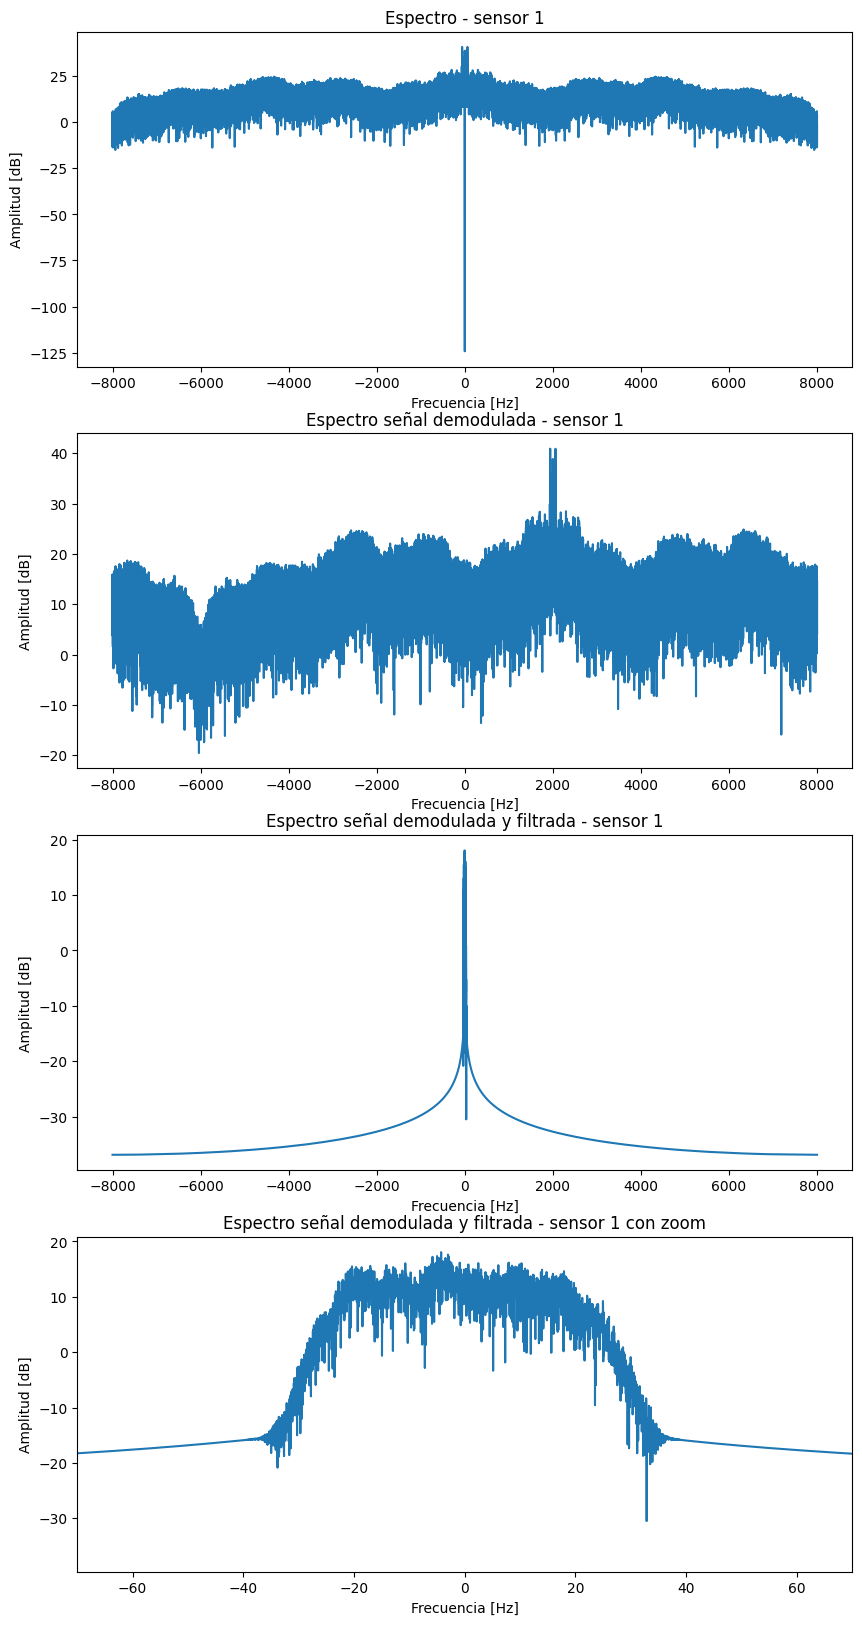

In [30]:
calc_db = lambda value: 10 * np.log10(np.abs(value+1e-20))

def calc_fft(data, Fs=1):
    fft = np.fft.fftshift(np.fft.fft(data))
    freq = np.fft.fftshift(np.fft.fftfreq(len(data), d=1/Fs))
    return fft,freq

def plot_fft(original, demodulated, filtered, i):
    fig,ax = plt.subplots(4,1, figsize=(10, 20))

    fft,freq = calc_fft(original, Fs=Fs)
    ax[0].plot(freq, calc_db(fft))
    ax[0].set_title('Espectro - sensor ' + str(i))
    ax[0].set_ylabel('Amplitud [dB]')
    ax[0].set_xlabel('Frecuencia [Hz]')

    fft,freq = calc_fft(demodulated, Fs=Fs)
    ax[1].plot(freq, calc_db(fft))
    ax[1].set_title('Espectro señal demodulada - sensor ' + str(i))
    ax[1].set_ylabel('Amplitud [dB]')
    ax[1].set_xlabel('Frecuencia [Hz]')

    fft,freq = calc_fft(filtered, Fs=Fs)
    ax[2].plot(freq, calc_db(fft))
    ax[2].set_title('Espectro señal demodulada y filtrada - sensor ' + str(i))
    ax[2].set_ylabel('Amplitud [dB]')
    ax[2].set_xlabel('Frecuencia [Hz]')

    ax[3].plot(freq, calc_db(fft))
    ax[3].set_title('Espectro señal demodulada y filtrada - sensor ' + str(i) + ' con zoom')
    ax[3].set_xlim(-B-50,B+50)
    ax[3].set_ylabel('Amplitud [dB]')
    ax[3].set_xlabel('Frecuencia [Hz]')

plot_fft(data[0], data_dem[0], data_filt[0], 1)

In [31]:
data_arr = [np.take(data_filt, sens_arr[0], axis=0), np.take(data_filt, sens_arr[1], axis=0),np.take(data_filt, sens_arr[2], axis=0)]

## Espectrograma temporal

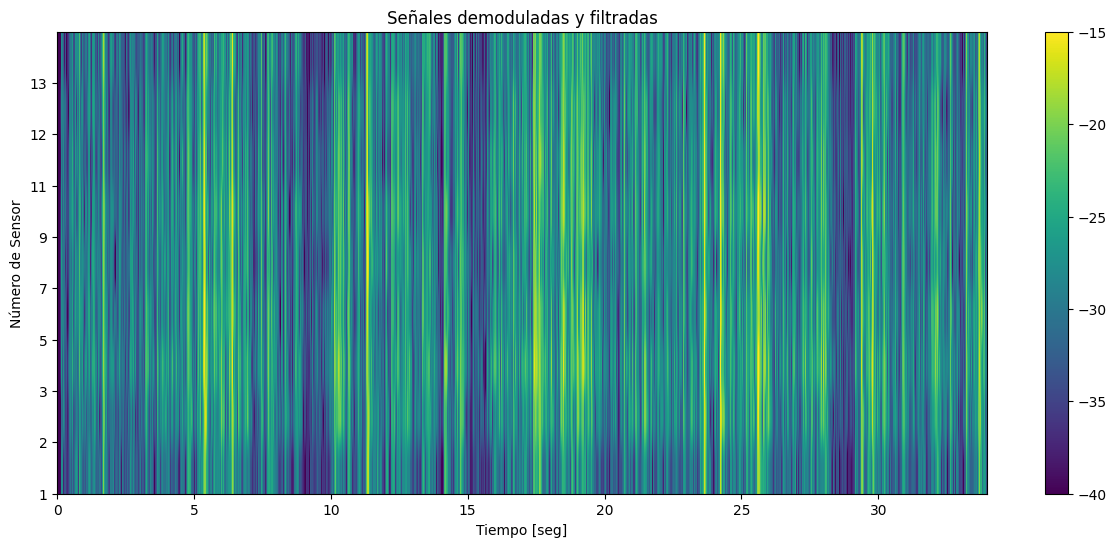

In [48]:
def plot_spatial_spect(array, sens_arr):
    plt.figure(figsize=(15, 6))
    img = plt.imshow(calc_db(array),
                     aspect="auto",
                     extent=[0, array.shape[1]/Fs, 0, array.shape[0]],  # Ajusto límites
                     origin="lower",
                     vmin = -40,
                     vmax = -15
                     )

    plt.yticks(np.arange(len(sens_arr)), labels = sens_arr)
    plt.title('Señales demoduladas y filtradas')
    plt.ylabel('Número de Sensor')
    plt.xlabel('Tiempo [seg]')
    plt.colorbar(img)
    plt.show()

plot_spatial_spect(data_arr[1],sens_arr[1])

Para un instante en específico, las señales aparentan ser muy similares para todos los sensores. Sin embargo, si comparamos los sensores de los extremos (el sensor 1 con el sensor 13), se pueden apreciar ciertas diferencias para algunos instantes.

La diferencia en las amplitudes a medida que transcurre el tiempo es causado por el hecho de que el orador varía su tono y realiza pausas, sumado a variaciones del ruido.

## Espectrograma espacial

In [33]:
cant_sens = len(sens_arr[1])
FFT_def = 128  # FFT de 128 puntos

fft = np.zeros((FFT_def, N), dtype=np.complex_)

for t in range(data_filt.shape[1]):
    fft[:, t], freqs = calc_fft (np.pad(data_arr[1][::, t], (0, FFT_def - cant_sens)))

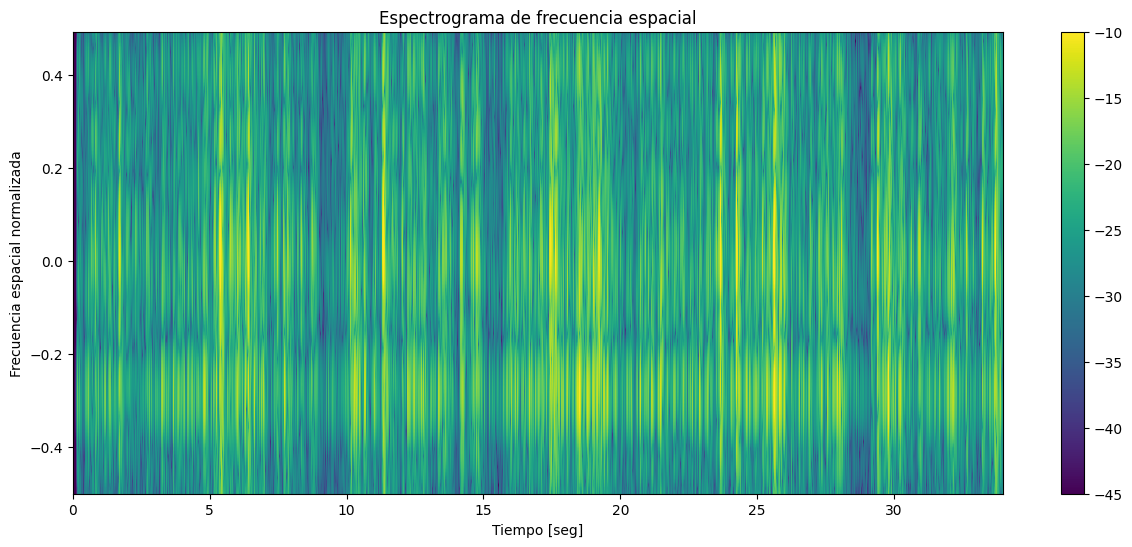

In [34]:
plt.figure(figsize=(15, 6))

img = plt.imshow(calc_db(fft),
                  aspect="auto",
                  extent=[0, fft.shape[1]/Fs, freqs[0], freqs[-1]],  # Ajusto límites
                  origin="lower",
                  vmin = -45,
                  vmax = -10
                 )

plt.title('Espectrograma de frecuencia espacial')
plt.ylabel('Frecuencia espacial normalizada')
plt.xlabel('Tiempo [seg]')
plt.colorbar(img)
plt.show()

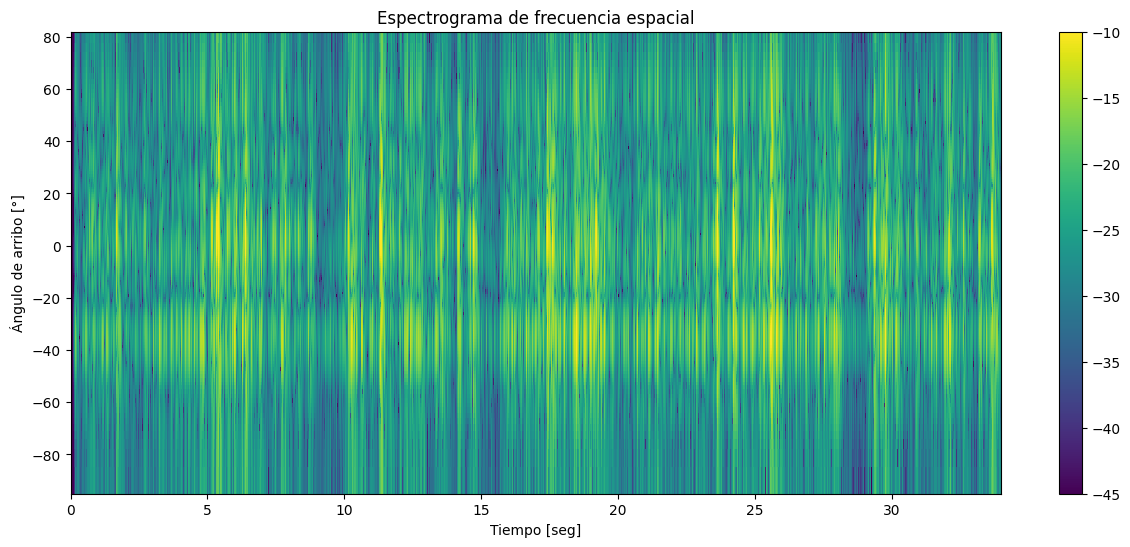

In [35]:
t = np.linspace(0, fft.shape[1]/Fs, fft.shape[1])
angle = np.arcsin(2*freqs) * (180/np.pi)
T, ANG = np.meshgrid(t, angle)

plt.figure(figsize=(15, 6))
img = plt.pcolormesh(T, ANG, calc_db(fft),
                    vmin = -45,
                    vmax = -10)

plt.title('Espectrograma de frecuencia espacial')
plt.ylabel('Ángulo de arribo [°]')
plt.xlabel('Tiempo [seg]')
plt.colorbar(img)
plt.show()

Se puede apreciar como la señal resulta ser bastante uniforme a lo largo del tiempo, tal como era de esperarse (ya que ni la persona, ni las fuentes de ruido, ni los objetos en los que se produce rebote de los ecos, se mueven). También se puede observar como hay una mayor amplitud aproximadamente para los $ϕ=45^o$, $ϕ=0^o$ y $ϕ=-45^o$.

En el centro del arreglo ($ϕ=0^o$) se encuentra el orador, a un metro de distancia del arreglo. Esto explica la máxima amplitud en este ángulo.

A los $-45^o$ respecto del eje del arreglo se encuentra el ruido de la radio AM, lo cual explica la amplitud en este ángulo.

Si bien para $ϕ=45^o$ la amplitud es mayor de la habitual, sigue siendo mucho menor que la amplitud a los $0^o$ y $-45^o$. Por lo tanto se lo adjudica a los ecos producidos dentro de la habitación donde se produjo la grabación.

## Observaciones de señales espaciales


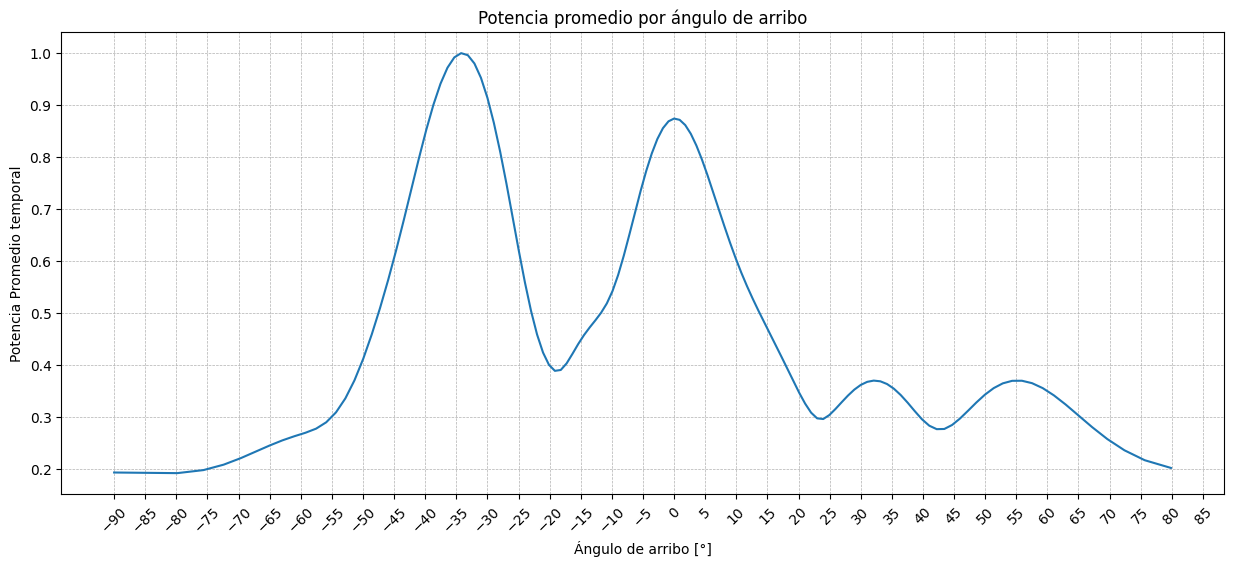

In [36]:
plt.figure(figsize=(15, 6))
pot_prom = np.abs(fft).sum(axis=1)
img = plt.plot(angle, pot_prom/np.max(pot_prom))

plt.title('Potencia promedio por ángulo de arribo')
plt.ylabel('Potencia Promedio temporal')
plt.xlabel('Ángulo de arribo [°]')
plt.xticks(np.arange(-90, 90, step=5), rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Como podemos observar en el gráfico anterior, tal como mencionamos anteriormente, tenemos dos principales fuentes de sonido. Una se encuentra en una dirección de $ϕ=0^o$ (sujeto orador) y otra de $ϕ \approx -40^o$ (radio AM).

# Punto 2

## Intervalo de ruido e interferencia

In [37]:
ti = 4.1
tf = 4.9
interference = data_arr[1][:,int(Fs*ti):int(Fs*tf)]

print("Intervalo seleccionado pre filtrado:")
display(Audio(data[0][int(Fs*ti):int(Fs*tf)], rate=Fs))

Intervalo seleccionado pre filtrado:


In [38]:
dir = 0   # Dirección de interes
u = sens_dist[1] * np.sin(dir)/ long_onda

## Cálculo de coeficientes

In [39]:
v_calc = lambda u, m: np.exp(-2j*np.pi*u*np.arange(m))/np.sqrt(m)

def calc_Rinv(x):
  N = len(x)
  R = np.zeros((N,N), dtype=complex)

  for t in range(N):
    R += np.outer(x[::,t], np.conj(x[::,t]))

  return R/N, np.linalg.inv(R/N)

### Beamformer de pesos uniformes

In [40]:
c_uniform = 1/np.sqrt(cant_sens)
c_uniform = np.full(cant_sens, c_uniform)
print(c_uniform)

[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333]


### Beamformer adaptativo


In [41]:
R, Rinv = calc_Rinv(interference)
v = v_calc(u, cant_sens)

c_smi = (Rinv @ v) / (np.conj(v) @ Rinv @ v)
print(c_smi)

[ 0.06789075+0.47954216j  0.49168198-0.17076927j  0.17013543+0.39672619j
 -0.23997656-0.43826852j  1.0765639 +0.08018263j  0.55767756-0.49406785j
  0.036793  -0.5203732j   0.48102017-0.37062252j  0.35821378+1.03765039j]


### Beamformer adaptativo con taper

In [42]:
cheb_window = ss.windows.chebwin(cant_sens, at=80)
vt = v * cheb_window
c_tsmi = (Rinv @ vt) / (np.conj(vt) @ Rinv @ vt)
print (c_tsmi)

print("\nPérdida por tapering:", calc_db(np.linalg.norm(c_tsmi @ v)**2), "dB")

[-0.15351658+0.27142j     1.12085197-0.06493217j -0.28553517+0.79984506j
 -0.34402101-0.89573032j  2.29065329+1.27039479j  0.77852738-0.54451702j
  0.32556504-0.83572836j  1.0161692 -0.75216731j -1.15859724+2.74781999j]

Pérdida por tapering: 2.7298653098389076 dB


## Patrón Beam

In [43]:
FFT_RES = 1024

def calc_beam_pat(coef):
    C, freq = calc_fft(np.pad(coef, pad_width=(0, FFT_RES - cant_sens)))
    beam_pattern = C*np.conj(C)
    beam_pattern = beam_pattern/np.max(beam_pattern)
    return beam_pattern, freq

In [44]:
#Beamformer de pesos uniformes
beam_unif, freq = calc_beam_pat(c_uniform)

#Beamformer adaptativo
beam_pattern, _ = calc_beam_pat(c_smi)

#Beamformer adaptativo con taper
beam_pattern_t, _ = calc_beam_pat(c_tsmi)

angle = np.arcsin(2*freq) * (180/np.pi)

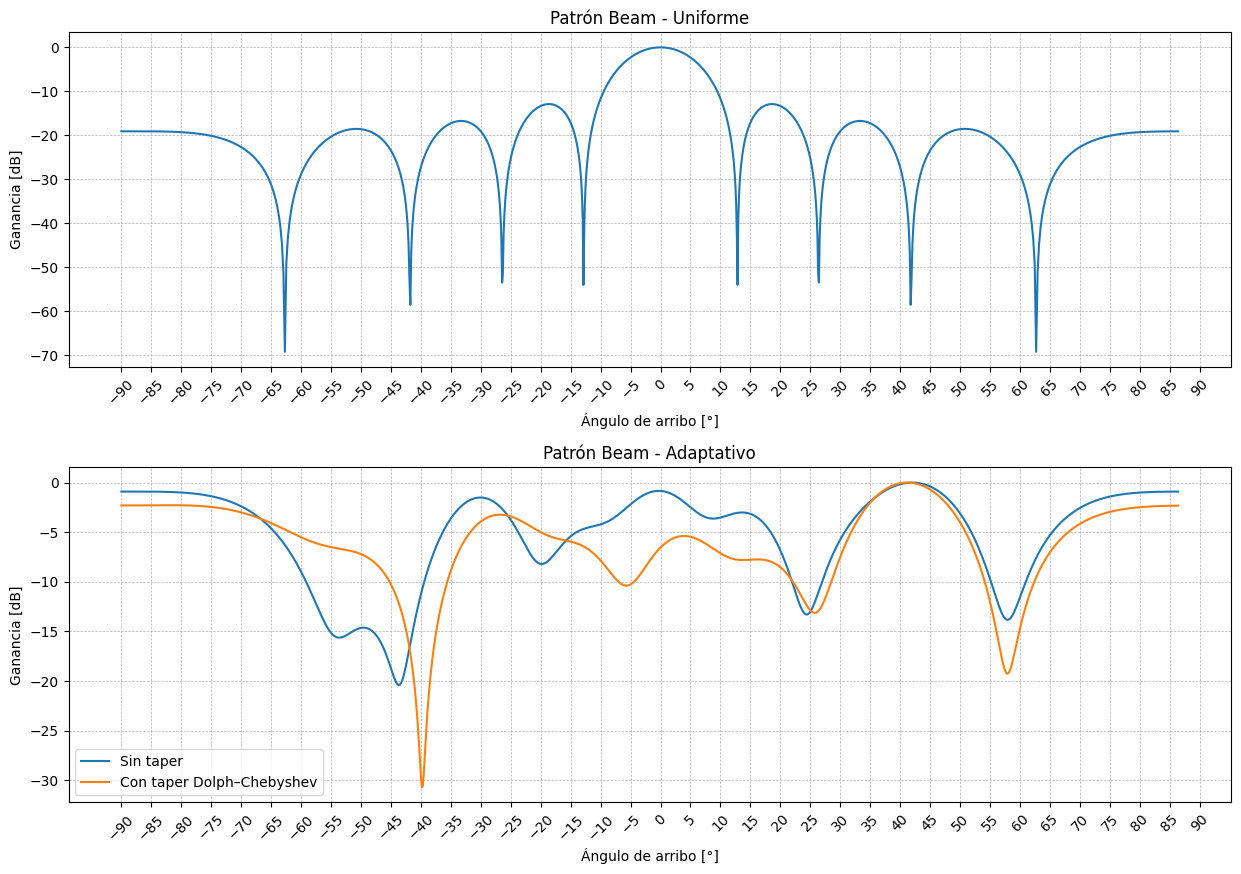

In [45]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'hspace': 0.3})

axs[0].plot(angle, calc_db(np.real(beam_unif)))
axs[0].set_title('Patrón Beam - Uniforme')

line1, = axs[1].plot(angle, calc_db(np.real(beam_pattern)), label='Sin taper')
line2, = axs[1].plot(angle, calc_db(np.real(beam_pattern_t)), label='Con taper Dolph–Chebyshev')
axs[1].set_title('Patrón Beam - Adaptativo')
axs[1].legend(handles=[line1, line2])

for ax in axs:
    ax.set_ylabel('Ganancia [dB]')
    ax.set_xlabel('Ángulo de arribo [°]')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticks(np.arange(-90, 91, step=5))

plt.show()

Aquí se puede observar el correcto funcionamiento, ya que se intenta eliminar la interferencia de la radio AM a los $45^o$ y ciertos ecos de otras direcciones, mientras que mantiene la voz del orador proveniente de los $0^o$.

Se decidió también utilizar un taper con una ventana de Dolph–Chebyshev, ya que permitía atenuar los lóbulos laterales de mejor manera. El beamformer con taper presenta mínimos menores en su patrón beam, causados por el efecto de aplicar el taper. Sin embargo, no se observan mejoras significativas respecto al beamformer sin taper. Esto se evaluará posteriormente con la SINR.

Para lograr una comparación adecuada con un modelo base, también se realizó un beamfomrer con pesos uniformes (el más sencillo). A pesar de que éste atenúa ciertas direcciones que no son las de interés, estas atenuaciones resultaron ser mucho mayores a las logradas con beamforming adaptativo.

Otro aspecto por considerar es que, al no poder encontrar un extracto del audio de duración prolongada en el que solo estuviera presente la interferencia, los beamformers adaptativos no resultaron tener un desempeño tan bueno como podrían haberlo tenido. Generalmente esto no es un problema, ya que se suele tener control sobre la señal deseada.


## Cálculo SINR

Para poder calcular la SINR necesitamos contar con $\sigma_s$. Al no contar con un fragmento en el que sólo se encuentre la señal deseada, se estimó este valor tomando un fragmento en el que solo se oyera al orador.

In [46]:
ti = 28.7
tf = 29.7
only_sepaker = data_arr[1][:,int(Fs*ti):int(Fs*tf)]
sigma2s = np.var(only_sepaker)

print("Seleccionado solo orador:")
display(Audio(data[0][int(Fs*ti):int(Fs*tf)], rate=Fs))

Seleccionado solo orador:


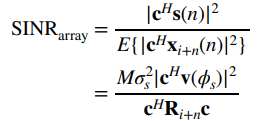

In [47]:
calc_SINR = lambda c, v: cant_sens*sigma2s * (np.linalg.norm(np.conj(c) @ v))**2 / (np.conj(c) @ R @ c)

SINR_unif = calc_SINR(c_uniform, v)
SINR_smi  = calc_SINR(c_smi, v)
SINR_tsmi = calc_SINR(c_tsmi, vt)

print("SINR_sens =", round(calc_db(sigma2s / np.var(interference)), 2), "dB")
print("SINR_unif =", round(calc_db(SINR_unif), 2), "dB")
print("SINR_smi  =", round(calc_db(SINR_smi), 2), "dB")
print("SINR_tsmi =", round(calc_db(SINR_tsmi), 2), "dB")

SINR_sens = 3.29 dB
SINR_unif = 30.75 dB
SINR_smi  = 182.54 dB
SINR_tsmi = 171.29 dB


Una vez calculada la SINR, se puede apreciar como, tal como era de esperarse, ésta es mucho mayor para el beamforming adaptativo respecto al beamformer con pesos uniforme.

A su vez, también se observa como la SINR al aplicar un taper disminuye respecto a no aplicarlo, tal como se había observado previamente de manera visual. Esto se lo atribuye a la pérdida por tapering de 2.73 dB previamente calculada, sumado a la pérdida de precisión en frecuencia espacial provocada por el mismo taper.